# Spelling Correction
Here we are going to implement a spelling correction system with Elasticsearch. It is recommended to read the [documentation](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-suggesters.html) before starting this part of your project. There are three steps and in each of which we add a feature and make an improvement. For the implementations, we will use [Python Elasticsearch Client](https://elasticsearch-py.readthedocs.io/).
Here is my email:
<a.akhoundi79@gmail.com>

Please contact me if there are any problems.

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import json
from tqdm import tqdm
import re
from copy import deepcopy

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In the beginning, We load the dataset and prepare it to upload to the index.

In [2]:
with open("IR_data_news_12k.json" , 'r') as f:
    data = json.load(f)

In [3]:
data_tmp = []
for i in tqdm(range(len(data))):
    doc = data[f'{i}']
    content = {
        "content_title":doc['content']
    }
    title = {
        "content_title":doc['title']
    }
    data_tmp.append(content)
    data_tmp.append(title)
    

100%|███████████████████████████████████████████████████| 12202/12202 [00:00<00:00, 373228.06it/s]


In [4]:
def load_data_to_elastic(es,data,index_name):
    data_bulk = [
        {
            "_index" : index_name,
            "_id" : i + 1,
            "_source": data[i]
        }
        for i in range(len(data))
    ]
    resp = helpers.bulk(
        es,
        data_bulk,
        index = index_name
    )
    print(resp)

### Section One
In this section, we start our work with a minimum implementation. To begin with, specify your [mapping explicitly](https://www.elastic.co/guide/en/elasticsearch/reference/current/explicit-mapping.html). By default, after uploading documents to your index, Elasticsearch uses type inference to specify the type of each field in your request and then, creates a special index for each of them. To optimize this process, It is better to use explicit mapping and specify the type of each field. Also, you can define [analyzers](https://www.elastic.co/guide/en/elasticsearch/reference/current/analyzer-anatomy.html) and do text processing. 
At this point, fill the TODO parts by considering the following points:
1. In the **index** part, define a [char_filter](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-charfilters.html) that replaces zero-width non-joiners (nim fasele) with an ASCII space.

2. In the **index** part, define an analyzer that extracts **Trigrams** and **Bigrams** from the text. You can define a [shingle](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-shingle-tokenfilter.html) filter and then use it in your analyzer.

3. In the mapping part, just define a field named **content_title**. use the analyzer defined in the **index** part to store your documents in the form of **N-grams**. You can store and index a field in multiple ways with different analyzers. See [Multi-fields with multiple analyzers](https://www.elastic.co/guide/en/elasticsearch/reference/current/multi-fields.html#_multi_fields_with_multiple_analyzers)


In [5]:
sc_mapping = { 
    "settings": {
    "index": {
        "analysis": {
          "analyzer": {
            "my_analyzer": {
              "tokenizer": "standard",
              "char_filter": [
                "nimfasele"
          ],
                "filter" : [
                    "gram"
                ]
        }
      },
      "char_filter": {
        "nimfasele": {
          "type": "mapping",
          "mappings": [ "\\u200C=>\\u0020"]
        }
      },
        "filter": {
         "gram":{
    
      "type": "shingle",
      "min_shingle_size": 2,
      "max_shingle_size": 3,
    
             }
             }     
    }
      #TODO: define your analyzers here
    }
  },
    "mappings": {
        "properties": {
            "content_title": {
                "type": "text",
                "fields": {
                    "ngram":{
                        "type" : "text",
                    "analyzer" : "my_analyzer"
                    }
                }
            }
            #TODO: define your fields here ?????????????????????????????????
        }
    }
}

In [6]:
# Name of index 
sc_index_name = 'ir_test_sc'

In [7]:
es = Elasticsearch("http://localhost:9200")

In [8]:
# Delete index if one does exist
if es.indices.exists(index=sc_index_name):
    es.indices.delete(index=sc_index_name)

# Create index
es.indices.create(index=sc_index_name, body=sc_mapping)

ConnectionError: Connection error caused by: ConnectionError(Connection error caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7f71905876a0>: Failed to establish a new connection: [Errno 111] Connection refused))

In [9]:
load_data_to_elastic(es,data_tmp,sc_index_name)

ConnectionError: Connection error caused by: ConnectionError(Connection error caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7f7169375160>: Failed to establish a new connection: [Errno 111] Connection refused))

The function `get_suggestion` takes an input text (the text which should be corrected) followed by `index_name`. Assign proper values to each parameter (follow the instructions from the PDF). See [phrase suggester](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-suggesters.html#phrase-suggester). 

In [10]:
def get_suggestions(text , index_name):
    resp = es.search(index=index_name,suggest={
        "text": text,
        "simple_phrase": {
            "phrase": {
                "smoothing" :{
          "laplace" : {
            "alpha" : 0.8
          }},
                "field":"content_title.ngram",
                "size": 5,
                "confidence": 1,
                "real_word_error_likelihood": 0.5,
                "max_errors" : 3,
                "direct_generator": [ 
                    {
                    "field": "content_title.ngram",
                    "prefix_length" : 2
                } 
                ]
            }
        }
    },size=0)
    return dict(resp)

In [11]:
texts = [
    "لیک برتر فوطبال",
    "تورنومنت شش جانبه",
    "طبعیض نژادی",
    "اردوی طیم امیذ",
    "جام ملب های آشیا",
    "کنره سیاسی آمریکا",
    "انغلاب اشلامی ایران",
    "فدراصیون فوتبال ایران",
    "لایهه مجلص خبرگان",
    "نحبگان دانشگاهی",
    "نمایند مجل",
    "فضاسازی کازب",
    "صلاح ایرادات شورای تگهبان",
    "تهریف های تاریخی",
    "قلیت های دینی",
    "تدارکان لازم",
]

In [12]:
for text in texts:
    print(get_suggestions(text,sc_index_name )['suggest']['simple_phrase'])
    print("========================")

[{'text': 'لیک برتر فوطبال', 'offset': 0, 'length': 15, 'options': [{'text': 'لیک برتر فوتبال', 'score': 1.4748909e-07}, {'text': 'لیک برتر فوبال', 'score': 1.4571046e-07}, {'text': 'لیک برتر فوتبالش', 'score': 1.3461788e-07}, {'text': 'لیک برتر فوتبالی', 'score': 1.3461788e-07}, {'text': 'لیک برتر فوتسال', 'score': 1.3412304e-07}]}]
[{'text': 'تورنومنت شش جانبه', 'offset': 0, 'length': 17, 'options': []}]
[{'text': 'طبعیض نژادی', 'offset': 0, 'length': 11, 'options': [{'text': 'طبیعی نژادی', 'score': 0.000108017055}, {'text': 'طبیعت نژادی', 'score': 4.4585144e-05}, {'text': 'طبعاً نژادی', 'score': 1.7813283e-05}, {'text': 'طبعتا نژادی', 'score': 1.1635694e-05}, {'text': 'طبیعا نژادی', 'score': 1.1635694e-05}]}]
[{'text': 'اردوی طیم امیذ', 'offset': 0, 'length': 14, 'options': [{'text': 'اردوی طیم امید', 'score': 1.8252989e-06}, {'text': 'اردوی طیم امیر', 'score': 1.8252989e-06}, {'text': 'اردوی طیم امیل', 'score': 1.8252989e-06}, {'text': 'اردوی طیم امین', 'score': 1.8252989e-06}, {'t

### Section Two
As you may have noticed, candidates for each token in the input text are generated by [Direct Generators](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-suggesters.html#_direct_generators). Usually, we assume that the user does not have misspellings in the first characters of each term in a sentence. Due to this assumption, the default value of `prefix_length` for each generator is set to 1 to considerably decrease the number of candidates for each token. Though setting this parameter to a higher value decreases response time, we cannot correct misspellings that occur at the beginning of each word. To address this problem, we can set the value of `prefix_length` to zero. It increases the number of candidates for each term. A better alternative is using reversed tokens. After reversing, characters at the beginning of the term are placed at the end of the term so, the misspelled characters will be taken into account by the candidate generator. In the figure below, You can see an example of using reversed tokens for generating better suggestions.
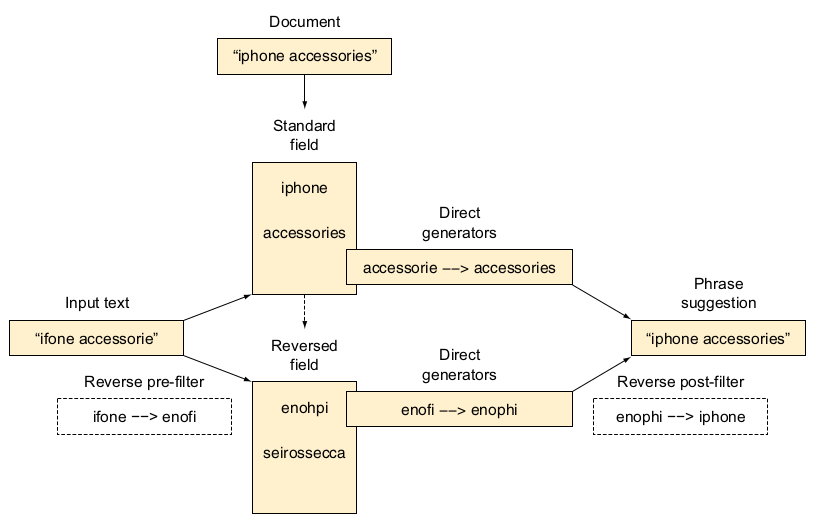

At this point, copy your mapping from the previous section to the TODO part then define another analyzer to reverse tokens (see [Reverse Token Filter](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-reverse-tokenfilter.html)). After defining the analyzer, use this analyzer to create another index of `content_title` (do not define another field).

In [16]:
sc_mapping_v1 = { 
    "settings": {
    "index": {
        "analysis": {
          "analyzer": {
                "my_analyzer": {
              "tokenizer": "standard",
              "char_filter": [
                "nimfasele"
          ],
                "filter" : [
                    "gram"
                ]
        }
              ,
            "rev_lyz": {
              "tokenizer": "standard",
              "char_filter": [
                "nimfasele"
          ],
                "filter" : ["reverse"]
        },
        
          
              
      },
      "char_filter": {
        "nimfasele": {
          "type": "mapping",
          "mappings": [ "\\u200C=>\\u0020"]
        }
      }, 
       "filter": {
         "gram":{
      "type": "shingle",
      "min_shingle_size": 2,
      "max_shingle_size": 3
             }
             }
    }
      
    }
  },
    "mappings": {
        "properties": {
            "content_title": {
                "type": "text",
                "fields": {
                    "rev":{
                        "type" : "text",
                    "analyzer" : "rev_lyz"
                    }
                }
            }
        }
        
    }
}

In [17]:
# Name of index 
sc_index_name_v1 = 'ir_test_sc_vv1'

In [18]:
# Delete index if one does exist
if es.indices.exists(index=sc_index_name_v1):
    es.indices.delete(index=sc_index_name_v1)

# Create index
es.indices.create(index=sc_index_name_v1, body=sc_mapping_v1)

/tmp/ipykernel_75174/1352140439.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index=sc_index_name_v1, body=sc_mapping_v1)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ir_test_sc_vv1'})

In [19]:
load_data_to_elastic(es,data_tmp,sc_index_name_v1)

(24404, [])


For this part, Copy your TODO part from the previous section to the cell bellow. Add another generator to the `direct_generator` part and use the index of reversed tokens that you have defined in the previous step. 

Hint: Use `pre_filter` and `post_filter` in your new generator. See [Direct Generators](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-suggesters.html#_direct_generators)

In [20]:
def get_suggestions_v1(text , index_name):
    resp = es.search(index=index_name,suggest={
        "text": text,
        "simple_phrase": {
            "phrase": {
                "smoothing": {
                    "laplace": {
                        "alpha": 0.8
                    }
                },
                "field": "content_title", 
                "size": 5,
                "confidence": 1.0,
                "real_word_error_likelihood": 0.5, 
                "max_errors" : 3,
                "direct_generator": [ 
                    {
                    "field": "content_title",
                    "prefix_length" : 2
                },
                    {
                    "field": "content_title.rev",
                    "prefix_length" : 2,
                    "pre_filter": "rev_lyz",
                    "post_filter": "rev_lyz"
                } 
                    
                ]
            }
        }
    },size=0)
    return dict(resp)

In [21]:
for text in texts:
    print(get_suggestions_v1(text,sc_index_name_v1 )['suggest']['simple_phrase'])
    print("========================")

[{'text': 'لیک برتر فوطبال', 'offset': 0, 'length': 15, 'options': [{'text': 'لیک برتر فوتبال', 'score': 2.1065025e-06}, {'text': 'لیک برتر فوتسال', 'score': 7.207492e-07}, {'text': 'لیک برتر فوتبالی', 'score': 4.9434544e-07}, {'text': 'لیک برتر فوتبالش', 'score': 1.7651091e-07}, {'text': 'لیک برتر فوبال', 'score': 5.382043e-08}]}]
[{'text': 'تورنومنت شش جانبه', 'offset': 0, 'length': 17, 'options': []}]
[{'text': 'طبعیض نژادی', 'offset': 0, 'length': 11, 'options': [{'text': 'طبیعی نژادی', 'score': 4.2907337e-05}, {'text': 'تبعیض نژادی', 'score': 2.19542e-05}, {'text': 'طبیعت نژادی', 'score': 1.4771972e-05}, {'text': 'طبعاً نژادی', 'score': 8.8953175e-06}, {'text': 'طبعی نژادی', 'score': 3.8154185e-06}]}]
[{'text': 'اردوی طیم امیذ', 'offset': 0, 'length': 14, 'options': [{'text': 'اردوی طیم امید', 'score': 3.7630937e-07}, {'text': 'اردوی طیم امیر', 'score': 3.0283118e-07}, {'text': 'اردوی طیم امین', 'score': 1.9613185e-07}, {'text': 'اردوی طیم امیل', 'score': 2.732974e-08}, {'text': '

### Section Three
Sometimes, using a synonym of a term in a query will lead to better results. For instance, for the query ***captain usq*** we might generate a candidate ***usa*** for the term 
**usq**, which is a synonym for ***america***. This allows us to present ***captain america*** to the user if this phrase scores high enough. To begin with, for the mapping phase, copy your mappings and settings from the previous section and add another analyzer that maps a term to its synonyms. See [Synonym token filter](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-synonym-tokenfilter.html). We have provided the required mappings for you in the file `synonyms.txt`. You should place the file in the directory of Elasticsearch and set the value of `sysnonyms_path` to `synonyms.txt`.

In [22]:
sc_mapping_v2 = { 
    "settings": {
    "index": {
        "analysis": {
          "analyzer": {
              "my_analyzer": {
              "tokenizer": "standard",
              "char_filter": [
                "nimfasele"
          ],
                "filter" : [
                    "gram"
                ]
        },
              "rev_lyz": {
              "tokenizer": "standard",
              "char_filter": [
                "nimfasele"
          ],
                "filter" : ["reverse"]
        },
          "syn_lyz": {
              "tokenizer": "standard",
              "char_filter": [
                "nimfasele"
          ],
                "filter" : ["synonym"]
        },
            
            
           
      },
      "char_filter": {
        "nimfasele": {
          "type": "mapping",
          "mappings": [ "\\u200C=>\\u0020"]
        }
      },
      "filter": {
           "gram":{
      "type": "shingle",
      "min_shingle_size": 2,
      "max_shingle_size": 3
             },
          "synonym": {
            "type": "synonym",
            "synonyms_path": "synonyms.txt"
          },
         
        }
    }
      #TODO ????
    }
  },
    "mappings": {
        "properties": {
            "content_title": {
                "type": "text",
                "fields": {
                    "syn":{
                        "type" : "text",
                    "analyzer" : "syn_lyz"
                    }
                }
            }
        }
        #TODO
    }
}

In [23]:
sc_index_name_v2 = 'ir_test_sc_v2'

In [24]:
# Delete index if one does exist
if es.indices.exists(index=sc_index_name_v2):
    es.indices.delete(index=sc_index_name_v2)

# Create index
es.indices.create(index=sc_index_name_v2, body=sc_mapping_v2)

/tmp/ipykernel_75174/3912228812.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index=sc_index_name_v2, body=sc_mapping_v2)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ir_test_sc_v2'})

In [25]:
load_data_to_elastic(es,data_tmp,sc_index_name_v2)

(24404, [])


For this part, Copy your TODO part from the previous section to the cell bellow. Then define another cadidate generator and use your new analyzer. 

HINT: Use `post_filter` in your generator to map generated cadidate tokens to their synonyms.

In [26]:
def get_suggestions_v2(text , index_name):
    resp = es.search(index=index_name,suggest={
        "text": text,
        "simple_phrase": {
            "phrase": {
                "smoothing": {
                    "laplace": {
                        "alpha": 0.8
                    }
                },#TODO,
                "field": "content_title", 
                "size": 5,
                "confidence": 1.0,
                "real_word_error_likelihood": 0.6, 
                "max_errors" : 3,
                "direct_generator": [ 
                    {
                    "field": "content_title",
                    "prefix_length" : 2
                },
                    {
                    "field": "content_title.reverse",
                    "prefix_length" : 2,
                    "pre_filter": "rev_lyz",
                    "post_filter": "rev_lyz"
                },
                    {
                    "field": "content_title.syn",
                    "prefix_length" : 2,
                    "post_filter": "syn_lyz"
                } 
                    #TODO  ?????????????
                ]
            }
        }
    },size=0)
    return dict(resp)

In [27]:
for text in texts:
    print(get_suggestions_v2(text,sc_index_name_v2 )['suggest']['simple_phrase'])
    print("====================================")

[{'text': 'لیک برتر فوطبال', 'offset': 0, 'length': 15, 'options': [{'text': 'لیک برتر فوتبال', 'score': 2.916758e-06}, {'text': 'لیک برتر فوتسال', 'score': 9.0580573e-07}, {'text': 'لیک برتر فوتبالی', 'score': 5.483038e-07}, {'text': 'لیک برتر فوتبالش', 'score': 1.9577728e-07}, {'text': 'لیک برتر فوبال', 'score': 7.321264e-08}]}]
[{'text': 'تورنومنت شش جانبه', 'offset': 0, 'length': 17, 'options': []}]
[{'text': 'طبعیض نژادی', 'offset': 0, 'length': 11, 'options': [{'text': 'اصل نژادی', 'score': 6.201929e-05}, {'text': 'طبیعی نژادی', 'score': 4.797327e-05}, {'text': 'حالت نژادی', 'score': 3.097413e-05}, {'text': 'آفرینش نژادی', 'score': 8.563256e-06}, {'text': 'خاصه نژادی', 'score': 8.563256e-06}]}]
[{'text': 'اردوی طیم امیذ', 'offset': 0, 'length': 14, 'options': [{'text': 'اردوی طیم رئیس', 'score': 8.8630526e-07}, {'text': 'اردوی طیم حاکم', 'score': 2.082924e-07}, {'text': 'اردوی طیم خان', 'score': 8.412694e-08}, {'text': 'اردوی طیم حکمران', 'score': 3.770931e-08}]}]
[{'text': 'جام 